# 한국어 비슷한 단어 모델 학습

1. DataFrame을 만든다 -> crawling을 하던 (crawl_query) 또는 저장된 data를 불러와서 dataframe으로 만든다
2. model_train을 한다. -> 결과: tokenized 단어 list + word2vec학습된 모델
3. create_tensors를 하면 모델을 tensor로 바꾸고 저장한다.

In [1]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
import os
import sys
import logging
import argparse
import gensim
from gensim import utils


logger = logging.getLogger(__name__)



def word2vec2tensor(word2vec_model, tensor_filename, binary=False):
    """Convert file in Word2Vec format and writes two files 2D tensor TSV file.

    File "tensor_filename"_tensor.tsv contains word-vectors, "tensor_filename"_metadata.tsv contains words.

    Parameters
    ----------
    word2vec_model_path : str
        Path to file in Word2Vec format.
    tensor_filename : str
        Prefix for output files.
    binary : bool, optional
        True if input file in binary format.

    """
    model = word2vec_model
    outfiletsv = tensor_filename + '_tensor.tsv'
    outfiletsvmeta = tensor_filename + '_metadata.tsv'

    with utils.open(outfiletsv, 'wb') as file_vector, utils.open(outfiletsvmeta, 'wb') as file_metadata:
        for word in model.index2word:
            file_metadata.write(gensim.utils.to_utf8(word) + gensim.utils.to_utf8('\n'))
            vector_row = '\t'.join(str(x) for x in model[word])
            file_vector.write(gensim.utils.to_utf8(vector_row) + gensim.utils.to_utf8('\n'))

    logger.info("2D tensor file saved to %s", outfiletsv)
    logger.info("Tensor metadata file saved to %s", outfiletsvmeta)
    
def model_train(dataframe, content_col, size=100, window=5):
    okt=Okt()
    result = []
    print('loading ', end='')
    for index, row, in df.iterrows():
        if (index % 1000 == 0):
            print('. ', end='')
        try:
            tokenlist = okt.pos(row[content_col], stem=True, norm=True) # 단어 토큰화
        except:
            print(index, end='')
            continue
        temp=[]
        for word in tokenlist:
            if word[1] in ["Noun"]: # 명사일 때만
                temp.append((word[0])) # 해당 단어를 저장함

        if temp: # 만약 이번에 읽은 데이터에 명사가 존재할 경우에만
            result.append(temp) # 결과에 저장
    print('\n\nFinished!')
    
    model = Word2Vec(result, size=size, window=window, min_count=5, workers=4, sg=0)
    return result, model

def print_similar(model_, query):
    try:
        model_result = model_.wv.most_similar(query)
        print(model_result)
    except KeyError:
        print('{} not in model vocabulary. Please try another query.'.format(query))
    
def create_tensors(model, output):
    word2vec2tensor(model.wv, output)

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime


def crawler(maxpage,query,s_date,e_date):
    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1 # 11= 2페이지 21=3페이지 31=4페이지 ...81=9페이지 , 91=10페이지, 101=11페이지
    #f = open(RESULT_PATH + filename, 'w', encoding='utf-8-sig')
    df = pd.DataFrame(columns=['date', 'title', 'contents'])
    results_list = []

    while page < maxpage_t:
        print(page, 'loading', end='')
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort=0&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        req = requests.get(url)
        # print(url)
        cont = req.content
        soup = BeautifulSoup(cont, 'html.parser')
        #print(soup)
        for urls in soup.select("._sp_each_url"):
            try :
                #print(urls["href"])
                if urls["href"].startswith("https://news.naver.com"):
                    #print(urls["href"])
                    news_detail = get_news(urls["href"])
                    # pdate, pcompany, title, btext
                    results_list.append((news_detail[1], news_detail[0], news_detail[2])) # date, title, contents
                    #f.write("{}\t{}\t{}\t{}\t{}\n".format(news_detail[1], news_detail[4], news_detail[0], news_detail[2],news_detail[3])) # new style
            except Exception as e:
                # print(e)
                continue
        page += 10
    df = pd.DataFrame(results_list, columns=['date', 'title', 'contents'])
    print('\nFinished!\n')
    return df

def get_news(n_url):
    print('.', end='')
    news_detail = []
    breq = requests.get(n_url)
    bsoup = BeautifulSoup(breq.content, 'html.parser')
    title = bsoup.select('h3#articleTitle')[0].text #대괄호는 h3#articleTitle 인 것중 첫번째 그룹만 가져오겠다.
    news_detail.append(title)
    pdate = bsoup.select('.t11')[0].get_text()[:11]
    news_detail.append(pdate)
    _text = bsoup.select('#articleBodyContents')[0].get_text().replace('\n', " ")
    btext = _text.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "")
    news_detail.append(btext.strip())
    news_detail.append(n_url)
    pcompany = bsoup.select('#footer address')[0].a.get_text()
    news_detail.append(pcompany)
    # news_detail [title, pdate, btext, n_url, pcompany]
    return news_detail

def crawl_query(max_pages, query,s_date='2020.06.01', e_date='2020.06.02'):
    maxpage = str(max_pages)
    return crawler(maxpage,query,s_date,e_date)

def crawl_n_save(max_pages, query,s_date='2020.06.01', e_date='2020.06.02'):
    maxpage = str(max_pages)
    df_temp = crawler(maxpage,query,s_date,e_date)
    df_temp.to_pickle("./data_{}.pkl".format(query))

## 예시 코드

In [3]:
df = crawl_query(1000, '코로나', s_date='2020.04.01')

1 loading............................11 loading..............21 loading.................31 loading...............41 loading............51 loading...................61 loading............71 loading...................81 loading...............91 loading...........101 loading..................111 loading.................121 loading...................131 loading..........141 loading............151 loading...............161 loading................171 loading..............181 loading...........191 loading............201 loading..............211 loading..............221 loading...........231 loading..........241 loading...............251 loading.............261 loading.............271 loading............281 loading.............291 loading...........301 loading..............311 loading...........321 loading..........331 loading................341 loading...........351 loading.............361 loading..........371 loading............381 loading...................391 loading..............401 loadi

In [4]:
result, model = model_train(df, 'contents')

loading . 

Finished!


In [5]:
print_similar(model, '대면')

[('하객', 0.9986556172370911), ('인증', 0.9983986616134644), ('흡연', 0.9982520341873169), ('개사', 0.9982223510742188), ('주년', 0.9979987144470215), ('부과', 0.9979167580604553), ('감사', 0.9978440403938293), ('오', 0.9977390170097351), ('메이', 0.9977235794067383), ('아시아나', 0.99772047996521)]


In [3]:
df = pd.read_pickle('test_corona_df.pkl')
df.head()

,date,title,contents
0,2020.06.02.,도쿄 코로나19 신규 확진 34명…'도쿄 경보' 첫 발령(종합2보),일본 전체 신규 감염자 51명…누적 1만7천712명(도쿄=연합뉴스) 박세진 특파원 ...
1,2020.06.02.,"도쿄, 19일만에 코로나19 신규 확진 30명 넘어…'도쿄 경보' 발령 검토",일본 수도인 도쿄도(東京都)에서 2일 하루 동안 34명이 새롭게 신종 코로나바이러스...
2,2020.06.02.,"도쿄, 코로나 확진자 2주만에 30명대...'제2파' 우려",긴급사태 해제 직후인 지난달 26일 도쿄의 출근길 표정. AP뉴시스 【도쿄=조은효 ...
3,2020.06.02.,도쿄 코로나 신규 확진 34명…'도쿄 경보' 발령 검토(종합),일본 긴급사태 해제 첫날 붐비는 지하철역(도쿄 로이터=연합뉴스) 일본의 신종 코로나...
4,2020.06.02.,"日도쿄, ‘도쿄 경보’ 첫 발령…코로나 확진자 34명",[서울신문]일본 전역에서 코로나19에 따른 긴급사태가 해제된 가운데 26일 일본 도...


In [4]:
result, model = model_train(df, 'contents')

loading . . . . 

Finished!


In [5]:
print_similar(model, '대면')

[('교육', 0.8222788572311401), ('강의', 0.8144059181213379), ('이수', 0.7947985529899597), ('무상급식', 0.786588191986084), ('접근성', 0.7861039042472839), ('거나', 0.7815482020378113), ('격', 0.7808001637458801), ('체험학습', 0.7588086724281311), ('직업', 0.7583791017532349), ('형태', 0.7552222609519958)]


In [1]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
import os
import sys
import logging
import argparse
import gensim
from gensim import utils
import csv

logger = logging.getLogger(__name__)

datafile = pd.read_csv('Stopwords_Korean.csv')
stopWordsKorean = datafile['words']


def word2vec2tensor(word2vec_model, tensor_filename, binary=False):
    """Convert file in Word2Vec format and writes two files 2D tensor TSV file.

    File "tensor_filename"_tensor.tsv contains word-vectors, "tensor_filename"_metadata.tsv contains words.

    Parameters
    ----------
    word2vec_model_path : str
        Path to file in Word2Vec format.
    tensor_filename : str
        Prefix for output files.
    binary : bool, optional
        True if input file in binary format.

    """
    model = word2vec_model
    outfiletsv = tensor_filename + '_tensor.tsv'
    outfiletsvmeta = tensor_filename + '_metadata.tsv'

    with utils.open(outfiletsv, 'wb') as file_vector, utils.open(outfiletsvmeta, 'wb') as file_metadata:
        for word in model.index2word:
            file_metadata.write(gensim.utils.to_utf8(word) + gensim.utils.to_utf8('\n'))
            vector_row = '\t'.join(str(x) for x in model[word])
            file_vector.write(gensim.utils.to_utf8(vector_row) + gensim.utils.to_utf8('\n'))

    logger.info("2D tensor file saved to %s", outfiletsv)
    logger.info("Tensor metadata file saved to %s", outfiletsvmeta)
    
def model_train(dataframe, content_col, size=100, window=5):
    okt=Okt()
    result = []
    print('loading ', end='')
    for index, row, in df.iterrows():
        if (index % 100 == 0):
            print('. ', end='')
        try:
            tokenlist = okt.pos(row[content_col], stem=True, norm=True) # 단어 토큰화
        except:
            print(index, end='')
            continue
        temp=[]
        
        for word in tokenlist:
            if word[1] in ["Noun"]: # 명사일 때만
                temp.append((word[0])) # 해당 단어를 저장함

        if temp: # 만약 이번에 읽은 데이터에 명사가 존재할 경우에만
            result.append(temp) # 결과에 저장
    print('\n\nFinished!')
    
    text = []
    for i in range(len(result)):
        text.append([word for word in result[i] if word not in stopWordsKorean])
        # print(str(len(result[i])-len(text[i])) + " stopwords are eliminated.")
        
    model = Word2Vec(text, size=size, window=window, min_count=5, workers=4, sg=0)
    return result, model

def print_similar(model_, query):
    try:
        model_result = model_.wv.most_similar(query)
        print(model_result)
        return model_result
    except KeyError:
        print('{} not in model vocabulary. Please try another query.'.format(query))
    
def create_tensors(model, output):
    word2vec2tensor(model.wv, output)
    
    

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime


def crawler(maxpage, query, s_date, e_date, week, save_dir):
    #maxpage = str(max_pages)
    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1 # 11= 2페이지 21=3페이지 31=4페이지 ...81=9페이지 , 91=10페이지, 101=11페이지
    #f = open(RESULT_PATH + filename, 'w', encoding='utf-8-sig')
    df = pd.DataFrame(columns=['date', 'title', 'contents'])
    results_list = []

    while page < maxpage_t:
        print(page, 'loading', end='')
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort=0&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        req = requests.get(url)
        # print(url)
        cont = req.content
        soup = BeautifulSoup(cont, 'html.parser')
        #print(soup)
        for urls in soup.select("._sp_each_url"):
            try :
                #print(urls["href"])
                # num_chkin = 0 #tmp aks 200609
                if urls["href"].startswith("https://news.naver.com"):
                    # num_chkin += 1
                    #print(urls["href"])
                    # news_detail = get_news(urls["href"])
                    n_url = urls["href"]
                    print('.', end='')
                    news_detail = []
                    breq = requests.get(n_url)
                    bsoup = BeautifulSoup(breq.content, 'html.parser')
                    title = bsoup.select('h3#articleTitle')[0].text #대괄호는 h3#articleTitle 인 것중 첫번째 그룹만 가져오겠다.
                    news_detail.append(title)
                    pdate = bsoup.select('.t11')[0].get_text()[:11]
                    news_detail.append(pdate)
                    _text = bsoup.select('#articleBodyContents')[0].get_text().replace('\n', " ")
                    btext = _text.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "")
                    news_detail.append(btext.strip())
                    news_detail.append(n_url)
                    pcompany = soup.select('#footer address')[0].a.get_text()
                    news_detail.append(pcompany)
                    # pdate, pcompany, title, btext
                    results_list.append((news_detail[1], news_detail[0], news_detail[2])) # date, title, contents
                    #f.write("{}\t{}\t{}\t{}\t{}\n".format(news_detail[1], news_detail[4], news_detail[0], news_detail[2],news_detail[3])) # new style
                # else:
                #     break
            except Exception as e:
                # print(e)
                continue
        page += 10
    df = pd.DataFrame(results_list, columns=['date', 'title', 'contents'])
    for i in range(len(df)):
        # print(df.contents[i])
        while "기자" not in df.contents[i] and "특파원" in df.contents[i] and "@" in df.contents[i]:
            if "기자" in df.contents[i]:
                ind_del = df.contents[i].rindex("기자")
                if ind_del/len(df.contents[i]) < 0.7:
                    ind_del = len(df.contents[i])
                    df.contents[i] = df.contents[i][0:ind_del-30]
                else:
                    df.contents[i] = df.contents[i][0:ind_del-10]
            elif "특파원" in df.contents[i]:
                ind_del = df.contents[i].rindex("특파원")
                if ind_del/len(df.contents[i]) < 0.7:
                    ind_del = len(df.contents[i])
                    df.contents[i] = df.contents[i][0:ind_del-30]
                else:
                    df.contents[i] = df.contents[i][0:ind_del-10]
            elif "@" in df.contents[i]:
                ind_del = df.contents[i].rindex("@")
                if ind_del/len(df.contents[i]) < 0.7:
                    ind_del = len(df.contents[i])
                    df.contents[i] = df.contents[i][0:ind_del-30]
                else:
                    df.contents[i] = df.contents[i][0:ind_del-10]
            else:
                ind_del = len(df.contents[i])
                df.contents[i] = df.contents[i][0:ind_del-30]
            # print(df.contents[i])
    df.to_pickle("./"+save_dir+"/data_{}_W{}.pkl".format(query,week))
    print('\nFinished!\n')
    return df





''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''' Settings & RUN '''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

save_dir = 'res_naverCrawl'

s_date_set = ["2019.06.01","2019.06.08","2019.06.15","2019.06.22","2019.06.29", \
          "2019.07.06","2019.07.13","2019.07.20","2019.07.27","2019.08.03", \
          "2019.08.10","2019.08.17","2019.08.24","2019.08.31","2019.09.07", \
          "2019.09.14","2019.09.21","2019.09.28","2019.10.05","2019.10.12", \
          "2019.10.19","2019.10.26","2019.11.02","2019.11.09","2019.11.16", \
          "2019.11.23","2019.11.30","2019.12.07","2019.12.14","2019.12.21", \
          "2019.12.28","2020.01.04","2020.01.11","2020.01.18","2020.01.25", \
          "2020.02.01","2020.02.08","2020.02.15","2020.02.22","2020.02.29", \
          "2020.03.07","2020.03.14","2020.03.21","2020.03.28","2020.04.04", \
          "2020.04.11","2020.04.18","2020.04.25","2020.05.02","2020.05.09", \
          "2020.05.16","2020.05.23"]

e_date_set = ["2019.06.07","2019.06.14","2019.06.21","2019.06.28","2019.07.05", \
          "2019.07.12","2019.07.19","2019.07.26","2019.08.02","2019.08.09", \
          "2019.08.16","2019.08.23","2019.08.30","2019.09.06","2019.09.13", \
          "2019.09.20","2019.09.27","2019.10.04","2019.10.11","2019.10.18", \
          "2019.10.25","2019.11.01","2019.11.08","2019.11.15","2019.11.22", \
          "2019.11.29","2019.12.06","2019.12.13","2019.12.20","2019.12.27", \
          "2020.01.03","2020.01.10","2020.01.17","2020.01.24","2020.01.31", \
          "2020.02.07","2020.02.14","2020.02.21","2020.02.28","2020.03.06", \
          "2020.03.13","2020.03.20","2020.03.27","2020.04.03","2020.04.10", \
          "2020.04.17","2020.04.24","2020.05.01","2020.05.08","2020.05.15", \
          "2020.05.22","2020.05.29"]
    
maxpage = '100'
query = ['인공지능', '금융', '산업']
word_similar_set = ["대면","ZOOM","zoom","원격수업","원격진료","온라인","기업", \
                "구글","삼성","네이버","카카오","삼성 SDS","페이스북","LG CNS", \
                "아마존","AWS","트위터","넷플릭스","배달의민족","요기요","우아한형제들"]





"""
for i in range(len(s_date_set)):
    for j in query:
        week = str(i+1).zfill(2)
        s_date = s_date_set[i]
        e_date = e_date_set[i]
        df = crawler(maxpage, j, s_date, e_date, week, save_dir)
        print("Crawling....."+week+"/"+str(len(s_date_set)))
"""
"""
fList = os.listdir("./"+save_dir+"/")
pkl_list = [file for file in fList if file.endswith(".pkl")]

for i in range(len(pkl_list)):
    pklName = "./"+save_dir+"/"+pkl_list[i]
    model_name = "./res_word2vec/model_" + query + "_" + pklName[-7:-4]
    df = pd.read_pickle(pklName)
    result, model = model_train(df, 'contents')
    create_tensors(model, model_name)
    for j in range(len(word_similar_set)):            
            word_similar = word_similar_set[j]
            print("Get similarity for " + word_similar)
            print_similar(model, word_similar)

"""

'\nfList = os.listdir("./"+save_dir+"/")\npkl_list = [file for file in fList if file.endswith(".pkl")]\n\nfor i in range(len(pkl_list)):\n    pklName = "./"+save_dir+"/"+pkl_list[i]\n    model_name = "./res_word2vec/model_" + query + "_" + pklName[-7:-4]\n    df = pd.read_pickle(pklName)\n    result, model = model_train(df, \'contents\')\n    create_tensors(model, model_name)\n    for j in range(len(word_similar_set)):            \n            word_similar = word_similar_set[j]\n            print("Get similarity for " + word_similar)\n            print_similar(model, word_similar)\n\n'

In [3]:
fList = os.listdir("./"+save_dir+"/")
pkl_list = [file for file in fList if file.endswith(".pkl")]

for i in range(len(pkl_list)):
    print("\nTraining & Saving \"{}\" dataframe...".format(pkl_list[i]))
    pklName = "./"+save_dir+"/"+pkl_list[i]
    model_name = "./res_word2vec/model_" + pkl_list[i][5:-4]
    model_save = "./res_models/model_"+ pkl_list[i][5:-4] + ".wv"
    df = pd.read_pickle(pklName)
    result, model = model_train(df, 'contents')
    create_tensors(model, model_name)
    model.save(model_save)


Training & Saving "data_금융_W01.pkl" dataframe...
loading . . . . . . . 

Finished!

Training & Saving "data_금융_W02.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_금융_W03.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_금융_W04.pkl" dataframe...
loading . . . . . . . . . 

Finished!

Training & Saving "data_금융_W05.pkl" dataframe...
loading . . . . . . . 

Finished!

Training & Saving "data_금융_W06.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_금융_W07.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_금융_W08.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_금융_W09.pkl" dataframe...
loading . . . . . . . 

Finished!

Training & Saving "data_금융_W10.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_금융_W11.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_금융_W12.pkl" dataframe...
loading 

loading . . . . . . 

Finished!

Training & Saving "data_산업_W47.pkl" dataframe...
loading . . . . . . . 

Finished!

Training & Saving "data_산업_W48.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_산업_W49.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_산업_W50.pkl" dataframe...
loading . . . . . . . 

Finished!

Training & Saving "data_산업_W51.pkl" dataframe...
loading . . . . . . . . 

Finished!

Training & Saving "data_산업_W52.pkl" dataframe...
loading . . . . . . . 

Finished!

Training & Saving "data_인공지능_W01.pkl" dataframe...
loading . . . . . . . . . . 

Finished!

Training & Saving "data_인공지능_W02.pkl" dataframe...
loading . . . . . . . . . 

Finished!

Training & Saving "data_인공지능_W03.pkl" dataframe...
loading . . . . . . . . . 

Finished!

Training & Saving "data_인공지능_W04.pkl" dataframe...
loading . . . . . . . . . 

Finished!

Training & Saving "data_인공지능_W05.pkl" dataframe...
loading . . . . . . . . . 

Finished!

Train

In [5]:
model_dir = os.listdir("./res_models/")
model_list = [file for file in model_dir]

model_list

['model_금융_W01.wv',
 'model_금융_W02.wv',
 'model_금융_W03.wv',
 'model_금융_W04.wv',
 'model_금융_W05.wv',
 'model_금융_W06.wv',
 'model_금융_W07.wv',
 'model_금융_W08.wv',
 'model_금융_W09.wv',
 'model_금융_W10.wv',
 'model_금융_W11.wv',
 'model_금융_W12.wv',
 'model_금융_W13.wv',
 'model_금융_W14.wv',
 'model_금융_W15.wv',
 'model_금융_W16.wv',
 'model_금융_W17.wv',
 'model_금융_W18.wv',
 'model_금융_W19.wv',
 'model_금융_W20.wv',
 'model_금융_W21.wv',
 'model_금융_W22.wv',
 'model_금융_W23.wv',
 'model_금융_W24.wv',
 'model_금융_W25.wv',
 'model_금융_W26.wv',
 'model_금융_W27.wv',
 'model_금융_W28.wv',
 'model_금융_W29.wv',
 'model_금융_W30.wv',
 'model_금융_W31.wv',
 'model_금융_W32.wv',
 'model_금융_W33.wv',
 'model_금융_W34.wv',
 'model_금융_W35.wv',
 'model_금융_W36.wv',
 'model_금융_W37.wv',
 'model_금융_W38.wv',
 'model_금융_W39.wv',
 'model_금융_W40.wv',
 'model_금융_W41.wv',
 'model_금융_W42.wv',
 'model_금융_W43.wv',
 'model_금융_W44.wv',
 'model_금융_W45.wv',
 'model_금융_W46.wv',
 'model_금융_W47.wv',
 'model_금융_W48.wv',
 'model_금융_W49.wv',
 'model_금융_W50.wv',


In [31]:
def print_similar(model_, query):
    try:
        model_result = model_.wv.most_similar(query)
        print(model_result)
        return model_result
    except KeyError:
        print('{} not in model vocabulary. Please try another query.'.format(query))

        
finance_models = []
for i in range(52):
    model_temp = gensim.models.Word2Vec.load('./res_models/{}'.format(model_list[i]))
    finance_models.append(print_similar(model_temp, "디지털"))

[('비실', 0.945334792137146), ('재외공관', 0.9068991541862488), ('공함', 0.8974473476409912), ('금융감독원', 0.89692223072052), ('눈치', 0.892565131187439), ('소프트웨어', 0.8902608156204224), ('누리집', 0.8896006941795349), ('공증', 0.8893685340881348), ('촉진', 0.8886565566062927), ('경리', 0.8819602131843567)]
[('이야기', 0.9751126170158386), ('소개', 0.9686547517776489), ('전략', 0.9660241603851318), ('컴퓨터공학', 0.9660229682922363), ('계장', 0.9654173254966736), ('연세대', 0.9653378129005432), ('세기', 0.9640803337097168), ('이슈', 0.9624744057655334), ('과학', 0.9612370729446411), ('이지문', 0.9586098194122314)]
[('예정', 0.9644852876663208), ('구축', 0.9579850435256958), ('선도', 0.9569998383522034), ('네트워크', 0.9546102285385132), ('플랫폼', 0.9534415602684021), ('활용', 0.9522559642791748), ('기반', 0.94450443983078), ('결제', 0.9440504312515259), ('출범', 0.9410536289215088), ('개요', 0.939410924911499)]
[('파트너', 0.9571378231048584), ('샐러드', 0.94179368019104), ('콘텐츠', 0.9320996999740601), ('금융결제원', 0.9169362783432007), ('컨설팅', 0.9160155057907104), 

[('재박', 0.8966090679168701), ('황인', 0.8098844885826111), ('전환', 0.8055713176727295), ('국', 0.7942383885383606), ('이진수', 0.7742668986320496), ('이석주', 0.7688097953796387), ('장경', 0.7668104767799377), ('최우현', 0.7611579895019531), ('방창용', 0.7579959630966187), ('삼정', 0.754102349281311)]
[('김정훈', 0.9675396084785461), ('창공', 0.9626494646072388), ('시너지', 0.9608137607574463), ('구로', 0.9535019397735596), ('김종민', 0.9530425071716309), ('볼트', 0.9519714713096619), ('유재', 0.9510033130645752), ('박석', 0.9497573971748352), ('마', 0.9495152235031128), ('무부', 0.9490014314651489)]
[('트랜스', 0.9041216373443604), ('포', 0.8584372401237488), ('테크', 0.8572119474411011), ('핀', 0.8515437245368958), ('한화', 0.8514082431793213), ('화생', 0.8494566679000854), ('메이', 0.8452227115631104), ('실', 0.834713339805603), ('환경', 0.8227214813232422), ('기술', 0.803566038608551)]
[('혁신', 0.9282957911491394), ('휴먼', 0.9014040231704712), ('인재', 0.8903398513793945), ('검토', 0.858673095703125), ('생태계', 0.8514482378959656), ('회', 0.84916681

In [26]:
test_model = gensim.models.Word2Vec.load('./res_models/model_인공지능_W52.wv')

vocab = list(test_model.wv.vocab)
X = test_model[vocab]

from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df_temp = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

C:\Users\steve\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


KeyError: 'x'

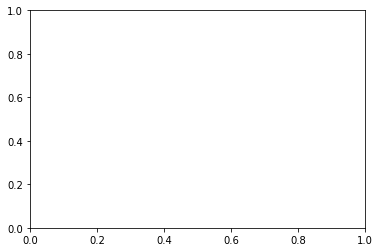

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)

plt.show()

In [30]:
print_similar(test_model, '디지털')

[('트랜스', 0.9288039207458496), ('포', 0.9179084300994873), ('메이', 0.8913238048553467), ('션', 0.8782243728637695), ('뉴딜', 0.8766234517097473), ('선제', 0.845299243927002), ('대응', 0.8289932012557983), ('차원', 0.8152667284011841), ('성장', 0.7932179570198059), ('휴먼', 0.7921728491783142)]


[('트랜스', 0.9288039207458496),
 ('포', 0.9179084300994873),
 ('메이', 0.8913238048553467),
 ('션', 0.8782243728637695),
 ('뉴딜', 0.8766234517097473),
 ('선제', 0.845299243927002),
 ('대응', 0.8289932012557983),
 ('차원', 0.8152667284011841),
 ('성장', 0.7932179570198059),
 ('휴먼', 0.7921728491783142)]

In [10]:
import pandas as pd

df = pd.read_pickle("word_similar_list.pkl")
df.head()

,query,week_num,word_similar,similar_words
0,금융,W01,줌,None
1,금융,W01,원격수업,None
2,금융,W01,원격진료,None
3,금융,W01,온라인,"[(판매, 0.9950112104415894), (이처럼, 0.99011099338..."
4,금융,W01,클라우드,"[(요소, 0.9829429388046265), (상, 0.9808036088943..."


In [12]:
df = df.dropna()
df.head()

,query,week_num,word_similar,similar_words
3,금융,W01,온라인,"[(판매, 0.9950112104415894), (이처럼, 0.99011099338..."
4,금융,W01,클라우드,"[(요소, 0.9829429388046265), (상, 0.9808036088943..."
5,금융,W01,모바일,"[(한경닷컴, 0.9931442141532898), (여름, 0.9930543899..."
6,금융,W01,빅데이터,"[(인프라, 0.9909763336181641), (구축, 0.97108638286..."
12,금융,W01,딥러닝,"[(모형, 0.9857240319252014), (예측, 0.982086122035..."


In [16]:
df.groupby('week_num').head()

,query,week_num,word_similar,similar_words
3,금융,W01,온라인,"[(판매, 0.9950112104415894), (이처럼, 0.99011099338..."
4,금융,W01,클라우드,"[(요소, 0.9829429388046265), (상, 0.9808036088943..."
5,금융,W01,모바일,"[(한경닷컴, 0.9931442141532898), (여름, 0.9930543899..."
6,금융,W01,빅데이터,"[(인프라, 0.9909763336181641), (구축, 0.97108638286..."
12,금융,W01,딥러닝,"[(모형, 0.9857240319252014), (예측, 0.982086122035..."
...,...,...,...,...
1839,금융,W52,온라인,"[(자연계, 0.9682503342628479), (손해, 0.90417140722..."
1840,금융,W52,클라우드,"[(안전성, 0.934285581111908), (기반, 0.931890487670..."
1841,금융,W52,모바일,"[(앱, 0.9013203978538513), (자동, 0.9008282423019..."
1842,금융,W52,빅데이터,"[(대조, 0.9151080846786499), (뱅킹, 0.896952152252..."
